# Tensorflow (No Keras!) Implementation
This notebook uses the (advanced) TensorFlow Subclassing  API <br/>
Documentation: https://www.tensorflow.org/api_docs/python/tf

In [39]:
# Install dependencies
!pip install tensorflow tensorflow-datasets

In [40]:
# Required dependencies
import tensorflow as tf
import tensorflow_datasets as tfds

# For visualisations
from matplotlib import pyplot as plt

In [41]:
# Load MNIST data
ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True, shuffle_files=True)

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label # Normalize images to have a value between 0 and 1 and convert to float32

batch_size = 32  # Define the batch size to be used in training and validation

ds_train = ds_train.map(normalize_img).shuffle(10000) # Normalize and shuffle the full training dataset with a buffer size of 10,000

# Calculate the number of total training examples to find out 20% of it for validation
num_train_examples = ds_train.cardinality().numpy()  # Get the total number of training examples
num_val_examples = int(num_train_examples * 0.2)     # Calculate 20% of the total number for validation set

train_data = ds_train.skip(num_val_examples).batch(batch_size) # Skip the first 20% of data to create the training dataset and batch it
val_data = ds_train.take(num_val_examples).batch(batch_size) # Take the first 20% of the shuffled dataset for validation and batch it

test_data = ds_test.map(normalize_img).batch(batch_size) # Apply normalization to test data and batch it

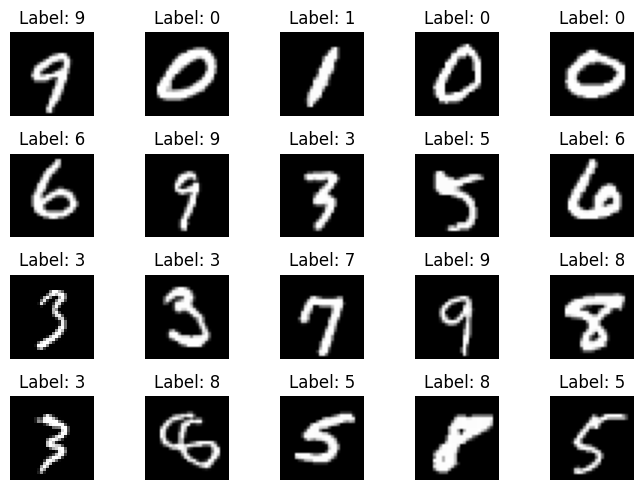

In [42]:
### Optional code to plot examples of the images
# Function to plot a grid of images
def plot_images_grid(dataset, num_rows=4, num_cols=5):
    plt.figure(figsize=(7, 5)) # larger figure size for better visibility
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_rows * num_cols):
            plt.subplot(num_rows, num_cols, i+1)
            plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')  # Reshape and plot image
            plt.title(f'Label: {labels[i].numpy()}')  # Display the label
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function with the training data
plot_images_grid(train_data)

In [43]:
# Define the model (as a class inheriting from tf.Module)
class SimpleNN(tf.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()  # Call the initializer of the parent class tf.Module
        # Initialize the first layer's weights and biases with random values
        self.weights1 = tf.Variable(tf.random.normal([784, 128], stddev=0.1))
        self.biases1 = tf.Variable(tf.zeros([128]))
        # Initialize the second layer's weights and biases with random values
        self.weights2 = tf.Variable(tf.random.normal([128, 10], stddev=0.1))
        self.biases2 = tf.Variable(tf.zeros([10]))

    def __call__(self, x):
        x = tf.reshape(x, [-1, 784])  # Flatten the image from a 28x28 matrix to a 784-element vector
        x = tf.add(tf.matmul(x, self.weights1), self.biases1)  # Compute the output of the first layer
        x = tf.nn.relu(x)  # Apply ReLU activation function to the first layer's output
        x = tf.add(tf.matmul(x, self.weights2), self.biases2)  # Compute the output of the second layer
        return x  # Return the final output of the network

# Create an instance of the SimpleNN class
model = SimpleNN()

In [44]:
# Define loss function
def loss_fn(logits, labels):
    # Use sparse softmax cross entropy with logits to calculate the loss
    # This function calculates softmax cross-entropy between logits and labels
    # It applies softmax on logits internally and handles the numerical instability
    # logits are the raw, unnormalized scores output by the last layer of the network
    # labels are the true labels associated with the data
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

# Define optimizer
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)

In [45]:
# Function to compute accuracy based on logits and true labels
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)  # Determine the predicted class from logits
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))  # Calculate mean accuracy across the batch

# Lists to store metrics over epochs
train_losses = []  # Store training loss per epoch
train_accuracies = []  # Store training accuracy per epoch
val_losses = []  # Store validation loss per epoch
val_accuracies = []  # Store validation accuracy per epoch

# Training step function to perform a single step of the training process
def train_step(images, labels):
    with tf.GradientTape() as tape:  # Context manager to record operations for automatic differentiation
        logits = model(images)  # Compute the logits (model outputs before activation function) by passing images to the model
        loss = loss_fn(logits, labels)  # Compute the loss by comparing the logits to the true labels
    gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients of the loss w.r.t. model variables
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Apply gradients to variables (gradient descent step)
    return loss  # Return the computed loss to track progress

# Validation step function to evaluate the model on the validation dataset
def validate_step(dataset):
    total_loss = 0  # Initialize total loss for the dataset
    total_accuracy = 0  # Initialize total accuracy for the dataset
    num_batches = 0  # Counter for batches processed
    for images, labels in dataset:
        logits = model(images)  # Compute logits for a batch
        loss = loss_fn(logits, labels)  # Compute loss for a batch
        accuracy = compute_accuracy(logits, labels)  # Compute accuracy for a batch
        total_loss += loss.numpy()  # Aggregate loss over all batches
        total_accuracy += accuracy.numpy()  # Aggregate accuracy over all batches
        num_batches += 1  # Increment batch counter
    avg_loss = total_loss / num_batches  # Calculate average loss per batch
    avg_accuracy = total_accuracy / num_batches  # Calculate average accuracy per batch
    return avg_loss, avg_accuracy  # Return average loss and accuracy

epochs = 10  # Define the number of epochs for training

# Loop over epochs for training and validation
for epoch in range(epochs):
    total_train_loss = 0  # Sum of training losses for epoch
    total_train_accuracy = 0  # Sum of training accuracies for epoch
    num_train_batches = 0  # Number of training batches processed

    # Iterate over batches in the training dataset
    for images, labels in train_data:
        loss = train_step(images, labels)  # Perform a training step and get the loss
        total_train_loss += loss.numpy()  # Aggregate training loss
        accuracy = compute_accuracy(model(images), labels)  # Compute training accuracy for the batch
        total_train_accuracy += accuracy.numpy()  # Aggregate training accuracy
        num_train_batches += 1  # Count training batches

    # Store and print epoch metrics for training
    train_losses.append(total_train_loss / num_train_batches)
    train_accuracies.append(total_train_accuracy / num_train_batches)

    # Perform validation after each epoch and store validation results
    val_loss, val_accuracy = validate_step(val_data)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print results for the epoch
    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, '
          f'Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')

print('Training complete.')


Epoch 1, Train Loss: 0.2988764740563929, Train Accuracy: 0.9193125, Validation Loss: 0.16051701660454273, Validation Accuracy: 0.9554166666666667
Epoch 2, Train Loss: 0.13112173791478077, Train Accuracy: 0.9653958333333333, Validation Loss: 0.11684439179549615, Validation Accuracy: 0.9664166666666667
Epoch 3, Train Loss: 0.0907178081975629, Train Accuracy: 0.9769583333333334, Validation Loss: 0.09826578179125985, Validation Accuracy: 0.9704166666666667
Epoch 4, Train Loss: 0.06827847581434374, Train Accuracy: 0.9828125, Validation Loss: 0.0747353981739531, Validation Accuracy: 0.9776666666666667
Epoch 5, Train Loss: 0.053117439225238434, Train Accuracy: 0.9876041666666666, Validation Loss: 0.06342908912943676, Validation Accuracy: 0.9813333333333333
Epoch 6, Train Loss: 0.04279545557626989, Train Accuracy: 0.9905625, Validation Loss: 0.0587333950678197, Validation Accuracy: 0.9809166666666667
Epoch 7, Train Loss: 0.03617632584667687, Train Accuracy: 0.9929375, Validation Loss: 0.054078

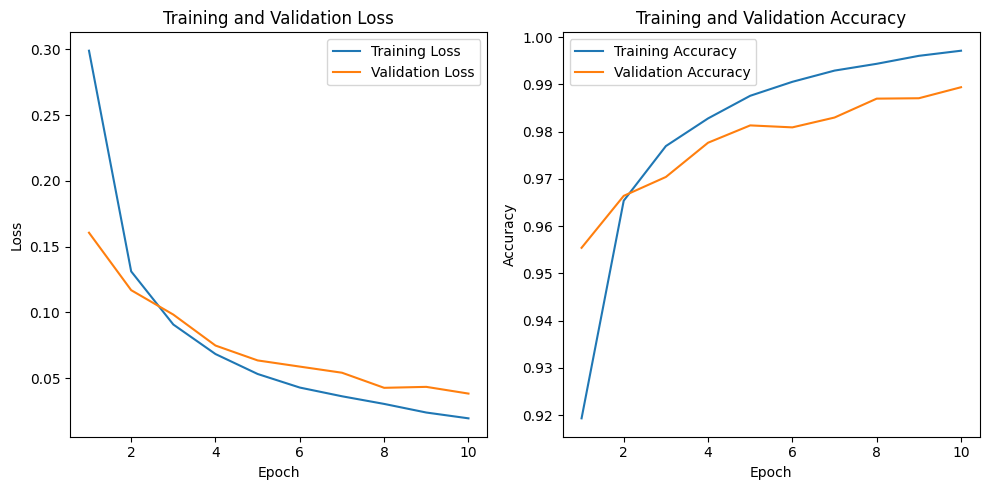

In [46]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
# Evaluation function
def evaluate(dataset):
    accuracy_metric = tf.metrics.Accuracy()
    for images, labels in dataset:
        logits = model(images)
        predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
        accuracy_metric.update_state(labels, predictions)
    return accuracy_metric.result().numpy()

# Evaluate the model
accuracy = evaluate(test_data)
print(f'Test accuracy: {accuracy}%')

Test accuracy: 0.9785343408584595%
